# TODO

1. Identify what distribution the data has
2. finish training and evaluating teh classifiers. add why recall is important

# ====================

# Analysis and development of a statistical model for the WDBC dataset

The WDBC dataset is the follow up data for cases of breast cancer. The full description of the data can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names). In summary, each row represents a single follow up, there are 34 columns of which one is the ID, one is the outcome of the case and the other 32 are real-valued features. We expect 569 data records.

In this notebook, we shall explore the data and train and compare a couple of simple classifers.

In [1]:
# we shall rely on numpy at a few instances throughout the notebook, so let us set the random seed.
import numpy as np

RANDOM_STATE = 10001
np.random.seed = RANDOM_STATE

from pprint import pprint as pp

import pandas as pd

from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
# single data loaded function. Assume 1 record per line
def load_data(fp, delimiter=','):
    with open(fp, 'r') as fin:
        rows = [line.replace('\n', '').split(delimiter) for line in fin.readlines() if line]
        print('{} rows of data loaded'.format(len(rows)))
        return rows
        

In [3]:
data = load_data('./data/wdbc.data')

569 rows of data loaded


    On load, there are 569 rows which is what we expected. However, this suggests no header row. Let us print the first row to confirm this.

In [4]:
print(data[0])

['842302', 'M', '17.99', '10.38', '122.8', '1001', '0.1184', '0.2776', '0.3001', '0.1471', '0.2419', '0.07871', '1.095', '0.9053', '8.589', '153.4', '0.006399', '0.04904', '0.05373', '0.01587', '0.03003', '0.006193', '25.38', '17.33', '184.6', '2019', '0.1622', '0.6656', '0.7119', '0.2654', '0.4601', '0.1189']


    Luckily, the data decription tells us that are 10 actual features each having a column for: mean, standard error and "worst" (or largest). 
    
    Rather than working with multi-dim arrays, let us convert the data to a DataFrame using pandas to allow us to set the columns and perform aggregations on the data easier.

In [5]:
df = pd.DataFrame(data)
df.head() # print the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
1,842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
2,84300903,M,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,...,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
4,84358402,M,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,...,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678


In [6]:
# let us create a little helper function to create the column names array
def create_column_names(features, cols_per_feature,):
    assert features and cols_per_feature
    columns = []
    for col in cols_per_feature:
        columns.extend([feature + '-' + col for feature in features])
    return columns

    The feature names from the data description are:
    
    Ten real-valued features are computed for each cell nucleus:
        a) radius (mean of distances from center to points on the perimeter)
        b) texture (standard deviation of gray-scale values)
        c) perimeter
        d) area
        e) smoothness (local variation in radius lengths)
        f) compactness (perimeter^2 / area - 1.0)
        g) concavity (severity of concave portions of the contour)
        h) concave points (number of concave portions of the contour)
        i) symmetry 
        j) fractal dimension ("coastline approximation" - 1)

In [7]:
feature_names = [
    'radius', 'texture',
    'perimeter', 'area',
    'smoothness', 'compactness', 
    'concavity', 'concave-points', 
    'symmetry', 'fractal-dim',
]

cols_per_feature = [
    'mean',
    'std-err',
    'largest',
]

numerical_cols = create_column_names(feature_names, cols_per_feature)
assert len(numerical_cols) == 30

# add the ID and diagnosis columns
columns = ['id', 'diagnosis'] + numerical_cols
assert len(columns) == 32
print(columns)

# set the column names on the dataframe
df.columns = columns

# let us also set the index to be the 'id' column
df.set_index('id', inplace=True)

assert len(df) == 569
df.head()

['id', 'diagnosis', 'radius-mean', 'texture-mean', 'perimeter-mean', 'area-mean', 'smoothness-mean', 'compactness-mean', 'concavity-mean', 'concave-points-mean', 'symmetry-mean', 'fractal-dim-mean', 'radius-std-err', 'texture-std-err', 'perimeter-std-err', 'area-std-err', 'smoothness-std-err', 'compactness-std-err', 'concavity-std-err', 'concave-points-std-err', 'symmetry-std-err', 'fractal-dim-std-err', 'radius-largest', 'texture-largest', 'perimeter-largest', 'area-largest', 'smoothness-largest', 'compactness-largest', 'concavity-largest', 'concave-points-largest', 'symmetry-largest', 'fractal-dim-largest']


,diagnosis,radius-mean,texture-mean,perimeter-mean,area-mean,smoothness-mean,compactness-mean,concavity-mean,concave-points-mean,symmetry-mean,...,radius-largest,texture-largest,perimeter-largest,area-largest,smoothness-largest,compactness-largest,concavity-largest,concave-points-largest,symmetry-largest,fractal-dim-largest
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
842517,M,20.57,17.77,132.9,1326,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956,0.1238,0.1866,0.2416,0.186,0.275,0.08902
84300903,M,19.69,21.25,130,1203,0.1096,0.1599,0.1974,0.1279,0.2069,...,23.57,25.53,152.5,1709,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
84358402,M,20.29,14.34,135.1,1297,0.1003,0.1328,0.198,0.1043,0.1809,...,22.54,16.67,152.2,1575,0.1374,0.205,0.4,0.1625,0.2364,0.07678


    Although the data description says there are no missing values, let us confirm this

In [8]:
assert not df.isnull().values.any()

    While the data says the data is to 4digit precision, we need to confirm the data types we are dealing with. Let us cast all the numerical columns to floats.

In [9]:
for col in numerical_cols:
    df[col] = df[col].astype(float)

# Q1. What is the mean, median and standard deviation of the perimeter feature?

    Let us calculate the values for all 3 cols first for fun, then show how easy it is with pandas

In [10]:
mean_func = lambda x: sum(x) / len(x)

def median(x):
    sorted_x = sorted(x)
    middle = (len(sorted_x) + 1) / 2.
    if middle % 1 != 0:
        return (sorted_x[int(middle - 0.5)] + sorted_x[int(middle + 0.5)]) / 2.
    else:
        return sorted_x[int(middle)]
    
def standard_dev(x):
    mean = mean_func(x)
    mean_diffs = sum([(x_i - mean)**2 for x_i in x])
    return (mean_diffs / len(x))**(1/2)


In [11]:
# we know there are 3 perimeter columns: permiter-mean, permiter-std-err, permiter-largest
perimeter_cols = ['perimeter-mean', 'perimeter-std-err', 'perimeter-largest']
descriptives = {}
for col in perimeter_cols:
    col_vals = df[[col]].values
    descriptives[col] = {
        'mean': mean_func(col_vals),
        'median': median(col_vals),
        'std': standard_dev(col_vals)
    }
pp(descriptives)

{'perimeter-largest': {'mean': array([107.26121265]),
                       'median': array([97.67]),
                       'std': array([33.57300157])},
 'perimeter-mean': {'mean': array([91.96903339]),
                    'median': array([86.34]),
                    'std': array([24.27761929])},
 'perimeter-std-err': {'mean': array([2.86605923]),
                       'median': array([2.289]),
                       'std': array([2.0200771])}}


    Or via pandas...

In [12]:
pp('Mean:\n{}'.format(df[perimeter_cols].mean()))
pp('Median:\n{}'.format(df[perimeter_cols].median()))
pp('Std:\n{}'.format(df[perimeter_cols].std()))

('Mean:\n'
 'perimeter-mean        91.969033\n'
 'perimeter-std-err      2.866059\n'
 'perimeter-largest    107.261213\n'
 'dtype: float64')
('Median:\n'
 'perimeter-mean       86.240\n'
 'perimeter-std-err     2.287\n'
 'perimeter-largest    97.660\n'
 'dtype: float64')
('Std:\n'
 'perimeter-mean       24.298981\n'
 'perimeter-std-err     2.021855\n'
 'perimeter-largest    33.602542\n'
 'dtype: float64')


# Q2. Is the first feature in the dataset "radius" normally distributed?

Next, let us visualise the distribution of the radius column.

    Although we showed the descriptive statistics above for multiple columns, let us just select the mean radius for this.
    
    Let us vialise the distribution first

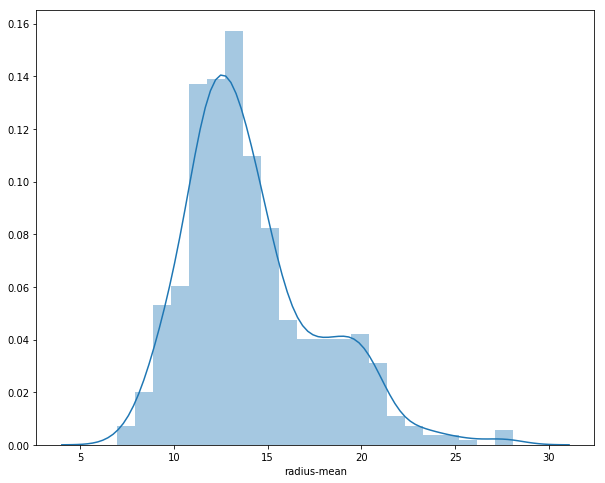

In [13]:
# visualise using seaborn

radius = df['radius-mean']

plt.figure(figsize=(10,8))
sns.distplot(radius)


    The data does not look normally distributed, and instead looks to be positively (right) skewed, but let us use the Shapiro-Wilk test to prove this. 

In [14]:
from scipy.stats import shapiro # let us use the conveniently wrapped scipy implementation

W, p = shapiro(radius)
print('W={}, p={}\n'.format(W, p))

# if the p value is greater than a threshold, alpha (usually ~0.05), we say it is normally distributed
alpha = 0.05
if p > alpha:
      print('Data is normally distributed as p(={})>alpha({})'.format(p, alpha))
else:
      print('Data is not normally distributed as p(={})<=alpha(={})'.format(p, alpha))


W=0.9410696029663086, p=3.1061551985026026e-14

Data is not normally distributed as p(=3.1061551985026026e-14)<=alpha(=0.05)


# Q3. Train and compare the results of 2 classifiers at predicting whether the diagnosis is malignant or benign.

    From looking at the data description, there are datapoints which are either correlated and/or calculated from other datapoints e.g. compactness is derived from the perimeter and area. We should remove these from the featureset as they will introduce no new information.
    
    Also, the 'std-err' suffixed columns are not of interest in the classification model as these values are not to do with the tumour, but instead are to do with data collection.
    
    Finally, the target shall be the 'diagnosis' column.

In [15]:
TARGET_COL = 'diagnosis'
FEATURE_COL_SUFFIXES = ['-mean', '-largest']
EXLCLUDE_COL_PREFIXES = ['compactness']

FEATURE_COLS = [col for col in df.columns 
                if any(col.endswith(suff) for suff in FEATURE_COL_SUFFIXES) 
                and not any(col.startswith(pref) for pref in EXLCLUDE_COL_PREFIXES) ]
FEATURE_COLS

['radius-mean',
 'texture-mean',
 'perimeter-mean',
 'area-mean',
 'smoothness-mean',
 'concavity-mean',
 'concave-points-mean',
 'symmetry-mean',
 'fractal-dim-mean',
 'radius-largest',
 'texture-largest',
 'perimeter-largest',
 'area-largest',
 'smoothness-largest',
 'concavity-largest',
 'concave-points-largest',
 'symmetry-largest',
 'fractal-dim-largest']

In [16]:
# Let us separate the features and target

X = df[FEATURE_COLS]
y = df[TARGET_COL]
assert len(X) == len(y)

    It is often good to visualise the data in 2 dimensions to see whether the data appears linearly seperable. 
    We shall use t-SNE to reduce to 2dims given the low feature dimensions (i.e. computing cost is not a concern)

In [17]:
from sklearn.manifold import TSNE

def plot_2d(X, labels, title, colours=['pink', 'green',]):
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)

    X_2d = tsne.fit_transform(X)
    
    unique_labels = np.unique(labels)
    
    plt.figure(figsize=(10,8))
    
    # iterate through each category and plot them, colouring them using the above colour array
    for i, category in enumerate(unique_labels):
        points = X_2d[labels == category]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colours[i], label=category)
        
    plt.title(title,
              fontdict=dict(fontsize=16))

    plt.legend(loc='best')

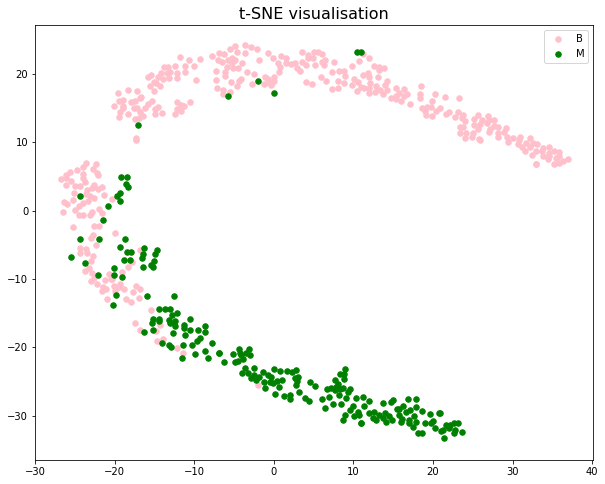

In [18]:
plot_2d(X, y, 't-SNE visualisation')

    From the above, we can see that there is a general separation between the benign(B) and malignant(M) records


    For our classifiers, we shall choose to compare Logistic Regression and a RandomForest classifer. Both of these will allow us to the most significant features which contributed to a positive class.
    
    First, we must encode our target to {0,1} as the above classifiers are binary classifiers (although the sklearn also implementations employ one-vs-rest for multi-class problems)
    In this case, we are interested in identifying whether a tumour is malignant (this has the highest cost), so we shall make this the target

In [19]:
encoder = lambda x : 1 if x == 'M' else 0 
y_enc = y.apply(encoder)

y_enc.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

    We have a aprox 2/5 malignent, 3/5 benign
    
    Next, we will define our classifiers. For this exercise, we will perform some hyperparameter tuning using a combination of grid search and cross validation (the original classifier of the dataset uses 10 fold cross validation).
    
    As we care most about classifying the positive target (i.e. malignant), we shall use the recall metric as our evaluation metric. Recall is the fraaction of relevant items (i.e. target=1) that have been correctrly classified.

In [20]:

details = {
    'log-reg': {
        'clf': LogisticRegression(max_iter=1000, tol=1e-3, penalty='l2', solver='lbfgs', random_state=RANDOM_STATE),
        'params': {
            'C': np.logspace(-6, -1, 10), # regularisation param. Smaller values specify stronger regularisation
        },
    },
    'rand-forest': {
        'clf': RandomForestClassifier(criterion='gini', random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'n_estimators': [int(n) for n in np.linspace(100,500,5)], # number of trees
            'max_depth': [int(m) for m in np.linspace(1, 3, 3)], # max depth of the trees
        },
    },
}

n_folds = 10

    Let us perform the Grid Search + Cross Val first

In [21]:

grid_res = {}

for clf_name in details:
    print('Starting Grid Search + CV for {}'.format(clf_name))
    t0 = time()
    grid = GridSearchCV(
        details[clf_name]['clf'], 
        details[clf_name]['params'],
        scoring='recall',
        cv=n_folds,
    )
    grid.fit(X,y_enc)
    
    print('Score: {}'.format(grid.score(X,y_enc)))
    t1 = time() - t0
    
    print('Took {}s to search param space. Best params are:\n{}'.format(t1, grid.best_params_))
    
    grid_res[clf_name] = grid

Starting Grid Search + CV for log-reg
Score: 0.9198113207547169
Took 4.5993804931640625s to search param space. Best params are:
{'C': 0.007742636826811277}
Starting Grid Search + CV for rand-forest


/home/adam/.conda/envs/jpm-interview/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adam/.conda/envs/jpm-interview/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score: 0.9433962264150944
Took 77.55259299278259s to search param space. Best params are:
{'max_depth': 3, 'n_estimators': 200}


    Let us visualise the spread for the 10 folds. We will use the best params for this

In [22]:
# first, let us train the classifiers using the default params.
cv_scores = {
    'model_name': [],
    'fold_idx': [],
    'recalls': [],
}

clfs = {
    'log-reg': LogisticRegression(**grid_res['log-reg'].best_params_, random_state=RANDOM_STATE),
    'rand-forest': RandomForestClassifier(**grid_res['rand-forest'].best_params_,  random_state=RANDOM_STATE),
}


for clf in clfs:
    scores = cross_val_score(clfs[clf], X, y_enc, cv=n_folds, scoring='recall', n_jobs=-1)
    
    cv_scores['model_name'].extend([clf] * n_folds ) 
    cv_scores['fold_idx'].extend(list(range(n_folds)))
    cv_scores['recalls'].extend(scores)

    
cv_df = pd.DataFrame.from_dict(cv_scores,)

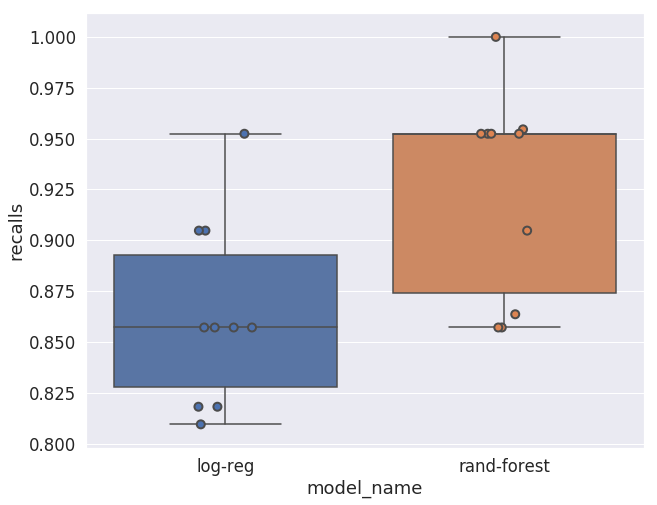

In [23]:
plt.figure(figsize=(10,8))

sns.set(font_scale=1.5)
sns.boxplot(x='model_name', y='recalls', data=cv_df,)
sns.stripplot(x='model_name', y='recalls', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [24]:
best_clf = RandomForestClassifier(**grid_res['rand-forest'].best_params_,  random_state=RANDOM_STATE)
best_clf.fit(X, y_enc)
preds = best_clf.predict(X,)
print('Recall score for the best classifier: {}'.format(recall_score(y_enc, preds)))

Recall score for the best classifier: 0.9433962264150944


# Next steps and Summary

    From the above, we can see that the RandomForest with 200 estimators and max depth of 3 is the best performing model.
    
    We have only tuned 2 of the many hyperparameters for this estimator type, and we could tune more in the hope of reducing the variation of the model's recall.
    
    We could also try other classifiers such as Support Vector Machines or other ensembles (e.g. Boosted Trees) to see whether this can improve performance over the Random Forest Classifier.